In [104]:
import ccxt
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
creds = json.loads(open('../creds.json', 'r').read())

In [3]:
exchange = ccxt.binance(creds['binance'])
# exchange = ccxt.phemex(creds['phemex'])

In [4]:
exchange.rateLimit

500

In [5]:
exchange.enableRateLimit = True

# Data downloading

## We fetch the last BTC tickers from Binance

In [6]:
from datetime import timezone 
import datetime
dt = datetime.datetime.now()   
utc_time = dt.replace(tzinfo = timezone.utc) 
utc_timestamp = utc_time.timestamp() 
  
timestamp = utc_timestamp
# timestamp *= 1000

In [7]:
timestamp

1615475817.835866

In [8]:
candles = np.array(exchange.fetch_ohlcv("BTC/USDT", '5m'))
n = candles.shape[0]

In [9]:
candles

array([[1.61532240e+12, 5.45662000e+04, 5.45662100e+04, 5.43681800e+04,
        5.44375100e+04, 2.15603279e+02],
       [1.61532270e+12, 5.44375200e+04, 5.44770000e+04, 5.43100600e+04,
        5.43655000e+04, 1.27617059e+02],
       [1.61532300e+12, 5.43655000e+04, 5.44395500e+04, 5.42640300e+04,
        5.44306700e+04, 1.12428691e+02],
       ...,
       [1.61547150e+12, 5.70389000e+04, 5.71500000e+04, 5.70100000e+04,
        5.70686500e+04, 4.12203183e+02],
       [1.61547180e+12, 5.70686600e+04, 5.71778400e+04, 5.69877200e+04,
        5.71747300e+04, 3.49911486e+02],
       [1.61547210e+12, 5.71747300e+04, 5.72385000e+04, 5.70668200e+04,
        5.70855800e+04, 2.27702957e+02]])

## Download historical data

In [294]:
start = exchange.parse8601('2020-01-01T00:00:00')
time_res = '1h'

candles = None
for _ in range(25):
    print("start:", int(start))
    a = np.array(exchange.fetch_ohlcv("BTC/USDT", time_res, int(start)))
    if (candles is None):
        candles = a
    else:
        candles = np.vstack([candles, a])
    start = a[-1][0]
    time.sleep(1)

start: 1577836800000
start: 1579633200000
start: 1581433200000
start: 1583247600000
start: 1585047600000
start: 1586844000000
start: 1588647600000
start: 1590444000000
start: 1592240400000
start: 1594047600000
start: 1595844000000
start: 1597640400000
start: 1599436800000
start: 1601233200000
start: 1603029600000
start: 1604826000000
start: 1606622400000
start: 1608422400000
start: 1610233200000
start: 1612029600000
start: 1613829600000
start: 1615478400000
start: 1615478400000
start: 1615478400000
start: 1615478400000


In [295]:
candles.shape

(10462, 6)

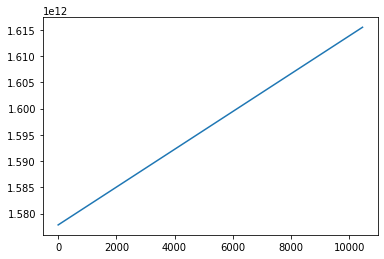

In [296]:
plt.plot(candles[:, 0])
plt.show()

In [297]:
data = pd.DataFrame()
data['timestamp'] = candles[:, 0]
data['date'] = pd.to_datetime(data['timestamp'] * 1000000)
data['open'] = candles[:, 1]
data['high'] = candles[:, 2]
data['low'] = candles[:, 3]
data['close'] = candles[:, 4]
data['volume'] = candles[:, 5]

In [298]:
print(data.iloc[0]['date'])
print(data.iloc[-1]['date'])

2020-01-01 00:00:00
2021-03-11 16:00:00


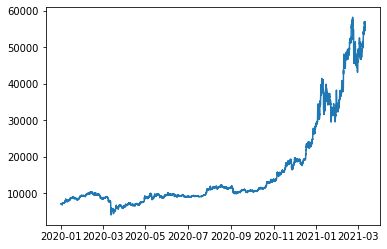

In [299]:
plt.plot(data['date'], data['close'])
plt.show()

# Signals creation

## MACD calculation

In [433]:
EWM1 = 12
EWM2 = 26
MACD = 18

ewm1 = data['close'].ewm(span=EWM1, adjust=False).mean()
ewm2 = data['close'].ewm(span=EWM2, adjust=False).mean()
macd = ewm1 - ewm2
macd9 = macd.ewm(span=MACD, adjust=False).mean()
data['macd'] = macd
data['macd2'] = macd9

## MACD derivative

In [434]:
data['macd_der'] = data['macd'] - data['macd'].shift(1)

## MACD crossovers calculations

In [435]:
macd2_shifted = data['macd2'].shift(1)
macd_shifted = data['macd'].shift(1)

crossovers_buy = (macd_shifted < macd2_shifted) & (data['macd'] >= data['macd2'])
data['crossover_buy'] = crossovers_buy

crossovers_sell = (macd_shifted > macd2_shifted) & (data['macd'] <= data['macd2'])
data['crossover_sell'] = crossovers_sell

# macd_der_sign = data['macd_der'] > 0
# crossovers_sell2 = (macd_der_sign != macd_der_sign.shift(1))
# data['crossover_sell'] = crossovers_sell2

In [436]:
data

,timestamp,date,open,high,low,close,volume,macd,macd2,macd_der,crossover_buy,crossover_sell
0,1.577837e+12,2020-01-01 00:00:00,7195.24,7196.25,7175.46,7177.02,511.814901,0.000000,0.000000,NaN,False,False
1,1.577840e+12,2020-01-01 01:00:00,7176.47,7230.00,7175.71,7216.27,883.052603,3.131054,0.329585,3.131054,False,False
2,1.577844e+12,2020-01-01 02:00:00,7215.52,7244.87,7211.41,7242.85,655.156809,7.668820,1.102136,4.537765,False,False
3,1.577848e+12,2020-01-01 03:00:00,7242.66,7245.00,7220.00,7225.01,783.724867,9.713521,2.008597,2.044701,False,False
4,1.577851e+12,2020-01-01 04:00:00,7225.00,7230.00,7215.03,7217.27,467.812578,10.587364,2.911625,0.873843,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
10457,1.615478e+12,2021-03-11 16:00:00,56347.19,56906.00,56340.06,56888.17,2034.679458,312.792546,280.534247,46.233787,True,False
10458,1.615478e+12,2021-03-11 16:00:00,56347.19,56906.00,56340.06,56896.10,2035.308554,346.083603,287.434179,33.291057,False,False
10459,1.615478e+12,2021-03-11 16:00:00,56347.19,56906.00,56340.06,56894.88,2035.880070,368.125046,295.927954,22.041443,False,False
10460,1.615478e+12,2021-03-11 16:00:00,56347.19,56906.00,56340.06,56898.99,2036.130817,381.526688,304.938347,13.401643,False,False


# Plotting

In [437]:
import matplotlib.dates as mdates

def split_data(start, end):
    i1 = int(start / 100 * data.shape[0])
    i2 = int(end / 100 * data.shape[0])
    return data.iloc[i1:i2]

def plot(start, end):
    graph_data = split_data(start, end)
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 15))
    ax1.plot(graph_data['date'], graph_data['close'])
    ax2.plot(graph_data['date'], graph_data['macd'])
    ax2.plot(graph_data['date'], graph_data['macd2'])
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y %H:%M'))

    for index, row in graph_data.iterrows():
        if (row['crossover_buy']):
            ax2.scatter(row['date'], row['macd'], color='b')
            ax1.scatter(row['date'], row['close'], color='b')
        if (row['crossover_sell']):
            ax2.scatter(row['date'], row['macd'], color='r')
            ax1.scatter(row['date'], row['close'], color='r')

    plt.show()

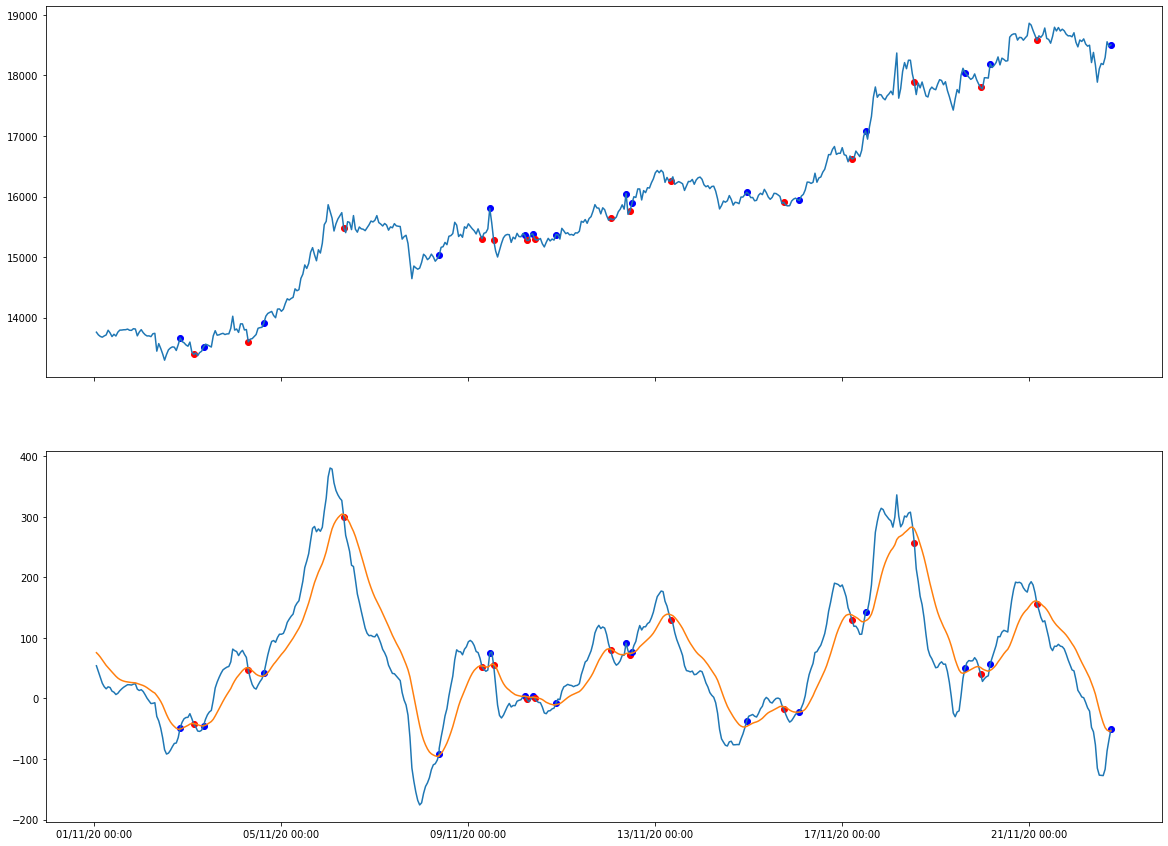

In [438]:
plot(70, 75)

# Backtest

In [439]:
def backtest(start, end):
    profits = []
    taker_fee = 0.1
    spread = 20

    test_data = split_data(start, end)
    
    last_buy = None
    for index, row in test_data.iterrows():
        if (row['crossover_buy'] and not last_buy):
            last_buy = row['close'] + spread
        if (row['crossover_sell'] and last_buy):
            price = row['close']
            variation = (price - last_buy) / last_buy * 100
            profits.append(variation - taker_fee)
            last_buy = None
    profits = np.array(profits)
    volatility = test_data['close'].std()
    return (profits, profits.sum(), volatility)

  0%- 10% -> profit 11.45%
 10%- 20% -> profit 0.87%
 20%- 30% -> profit 17.16%
 30%- 40% -> profit -4.23%
 40%- 50% -> profit -0.15%
 50%- 60% -> profit -14.03%
 60%- 70% -> profit -3.39%
 70%- 80% -> profit 21.71%
 80%- 90% -> profit 49.06%
 90%-100% -> profit 45.90%


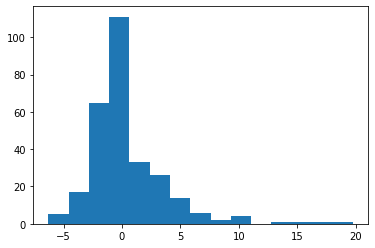

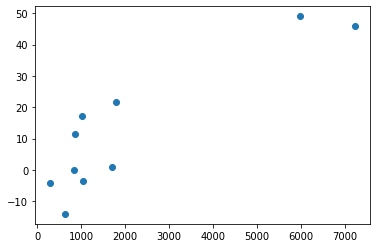

Total: 124.35% for 287 trades


In [440]:
splits = 10
batch_size = 100 / splits

pnl_total = []
trades = 0

x = []
y = []

for i in range(splits):
    start = batch_size * i
    end = batch_size * i + batch_size
    pnl, total, std = backtest(start, end)
    print("{:3.0f}%-{:3.0f}% -> profit {:.2f}%".format(start, end, total))
    pnl_total += list(pnl)
    trades += pnl.shape[0]
    
    x += [std]
    y += [total]

plt.hist(pnl_total, bins=15)
plt.show()

plt.scatter(x, y)
plt.show()

print("Total: {:.2f}% for {} trades".format(np.array(pnl_total).sum(), trades))

# Strategy testing

In [219]:
good_splits = [
    [50.5, 51.5],
    [54, 54.7],
]

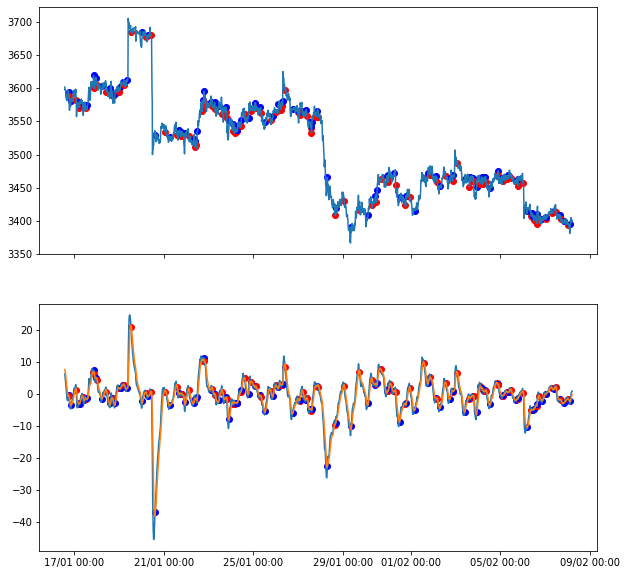

In [234]:
plot(2, 4.9)

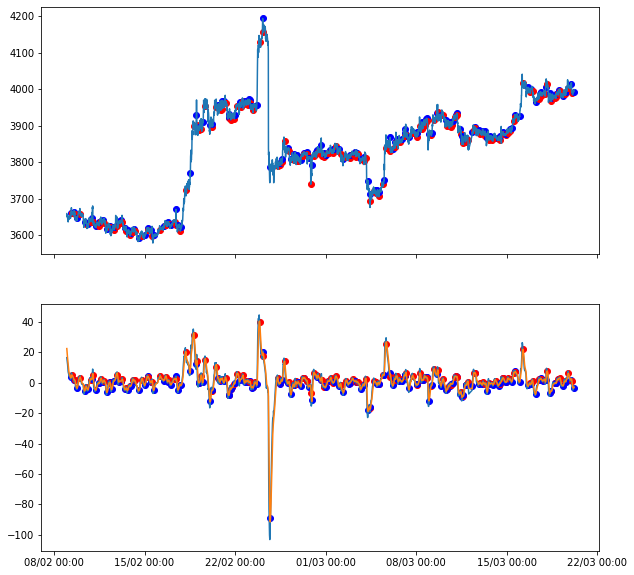

In [232]:
plot(5, 10)

# Fetch balance

In [18]:
balance = exchange.fetch_balance()

In [20]:
balance['USDT']['total']

100.0

In [445]:
exchange.fetch_open_orders("BTC/USDT")

InvalidNonce: binance {"code":-1021,"msg":"Timestamp for this request is outside of the recvWindow."}

# Tweeting

In [411]:
import tweepy

In [413]:
auth = tweepy.OAuthHandler(creds['twitter']['apiKey'], 
    creds['twitter']['secret'])
auth.set_access_token(creds['twitter']['accessToken'], 
    creds['twitter']['accessTokenSecret'])

api = tweepy.API(auth)

try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


In [414]:
api.update_status("Hello! This tweet is sent from a #Python notebook :)")

Status(_api=<tweepy.api.API object at 0x1187a88b0>, _json={'created_at': 'Mon Mar 08 22:03:27 +0000 2021', 'id': 1369046127404810244, 'id_str': '1369046127404810244', 'text': 'Hello! This tweet is sent from a #Python notebook :)', 'truncated': False, 'entities': {'hashtags': [{'text': 'Python', 'indices': [33, 40]}], 'symbols': [], 'user_mentions': [], 'urls': []}, 'source': '', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 1369041402995281922, 'id_str': '1369041402995281922', 'name': 'MACD crypto bot', 'screen_name': 'bot_macd', 'location': '', 'description': "I'm a bot.\nI buy every MACD crossover on $BTC.\nI tweet my trades and current balance.\nMy father is @AirM4rx.\n#btc", 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 0, 'friends_count': 1, 'listed_count': 0, 'created_at': 'Mon Mar 08 21:44:56 +0000 2021

Tweet with matplotlib visualization

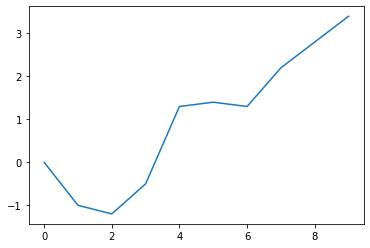

In [420]:
# Random matplotlib graph
x = list(range(10))
y = [0, -1, -1.2, -0.5, 1.3, 1.4, 1.3, 2.2, 2.8, 3.4]

plt.plot(x, y)
plt.savefig("/tmp/vis.png")

In [421]:
media = api.media_upload("/tmp/vis.png")
tweet = "Testing to tweet a #matplotlib graph!!!"
post_result = api.update_status(status=tweet, media_ids=[media.media_id])